In [1]:
# Import multiple essential libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
import time

from wordcloud import WordCloud
from wordcloud import STOPWORDS

# ignore the warning message
import warnings
warnings.filterwarnings('ignore')


## Data Access

In [2]:
# Data Insights:
# Few problems to be solved:
# 1. We wish to understand why 'good' employee wish to leave. 
# 2. Predict who is likely to leave so that finding methods to prevent them from leaving (saving cost)

In [4]:
# Kaggle HR Analytics 
# URL: https://www.kaggle.com/datasets/vjchoudhary7/hr-analytics-case-study

In [5]:
# Access files with relative path
path = 'dataset/'
employee = pd.read_csv(path + 'employee_survey_data.csv')
general = pd.read_csv(path + 'general_data.csv')
in_time = pd.read_csv(path + 'in_time.csv')
manager_survey = pd.read_csv(path + 'manager_survey_data.csv')
out_time = pd.read_csv(path + 'out_time.csv')


### Data Understanding

In [6]:
def df_exploration(dataframe):
    """
        Information about the DataFrame
        # Columns Data Type
        # Data Frame shape
        # Columns Name
        # Columns Description
        # First 5 Data Samples 
    """
    features_dtypes = dataframe.dtypes
    rows,columns = dataframe.shape
    
    missing_values_cols = dataframe.isnull().sum()
    missing_col = missing_values_cols.sort_values(ascending = False)
    features_names = missing_col.index.values
    missing_values = missing_col.values

    print('=' * 50)
    print('===> This data frame contains {} rows and {} columns'.format(rows,columns))
    print('=' * 50)

    print("{:13}{:13}{:30}{:15}".format('Feature Name'.upper(),
                                        'Data Format'.upper(),
                                        'Number of Missing Values'.upper(),
                                        'The first five samples'.upper()))

    for features_names, features_dtypes, missing_values in zip(features_names,features_dtypes[features_names],missing_values):
        print('{:15} {:14} {:20}'.format(features_names, str(features_dtypes), str(missing_values) + '-' +
                                         str(round(100*missing_values/sum(missing_col),3))+' %'), end=" ")

        for i in range(5):
            print(dataframe[features_names].iloc[i], end=",")

        print("="*50)
        

In [7]:
df_exploration(employee)

===> This data frame contains 4410 rows and 4 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FIVE SAMPLES
WorkLifeBalance float64        38-45.783 %          2.0,4.0,1.0,3.0,3.0,==================================================
EnvironmentSatisfaction float64        25-30.12 %           3.0,3.0,2.0,4.0,4.0,==================================================
JobSatisfaction float64        20-24.096 %          4.0,2.0,2.0,4.0,1.0,==================================================
EmployeeID      int64          0-0.0 %              1,2,3,4,5,==================================================


In [8]:
df_exploration(general)

===> This data frame contains 4410 rows and 24 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FIVE SAMPLES
NumCompaniesWorked float64        19-67.857 %          1.0,0.0,1.0,3.0,4.0,==================================================
TotalWorkingYears float64        9-32.143 %           1.0,6.0,5.0,13.0,9.0,==================================================
Age             int64          0-0.0 %              51,31,32,38,32,==================================================
Attrition       object         0-0.0 %              No,Yes,No,No,No,==================================================
YearsSinceLastPromotion int64          0-0.0 %              0,1,0,7,0,==================================================
YearsAtCompany  int64          0-0.0 %              1,5,5,8,6,==================================================
TrainingTimesLastYear int64          0-0.0 %              6,3,2,5,2,==================================================
StockOptionLevel int64  

In [10]:
df_exploration(manager_survey)

===> This data frame contains 4410 rows and 3 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FIVE SAMPLES
EmployeeID      int64          0-nan %              1,2,3,4,5,==================================================
JobInvolvement  int64          0-nan %              3,2,3,2,3,==================================================
PerformanceRating int64          0-nan %              3,4,3,3,3,==================================================


In [11]:
def time_adjust(time_df, col_adjust,target_name,thresholds = 0.8):
    # Assume 1st column in Employee ID 
    time_df.rename(columns = {col_adjust: target_name}, inplace = True)
    # drop column with NaN, assume it is public holiday as it is all NaN or for some reason, he/she is absent from the work
    #time_df.dropna(thresh=time_df.shape[0]*thresholds,how='all',axis=1,inplace = True)
    
    # replace NaT with 0s
    #time_df.replace({pd.NaT: 0}, inplace=True)
    time_df.fillna(0, inplace = True)
    # Convert all columns to datetime format using pandas.to_datetime
    time_df.iloc[:,1:]= time_df.iloc[:,1:].apply(pd.to_datetime, errors='coerce')
    return time_df


In [12]:
in_time = time_adjust(in_time,"Unnamed: 0","EmployeeID")
ID = in_time['EmployeeID'].copy(deep = True)
out_time = time_adjust(out_time,"Unnamed: 0","EmployeeID")

total_time = out_time - in_time
total_time['EmployeeID'] = ID

# Double Check
# total_time.head()

total_time['Average time'] = total_time.iloc[:,1:].median(axis = 1)

employee_time = total_time[['EmployeeID', 'Average time']].copy(deep = True)


In [13]:
df = general.copy(deep = True)
df = df.merge(employee, how = 'inner', on = 'EmployeeID')
df = df.merge(manager_survey, how = 'inner', on = 'EmployeeID')
df = df.merge(employee_time, how = 'inner', on = 'EmployeeID')
# With data dictionary, values from integer are converted back String for visualisation (better understanding)
df['Education'] = df['Education'].replace({ 1 : 'Below College', 2: 'College',3: 'Bachelor',4: 'Master',5 : 'Doctor'})
df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
df['JobInvolvement'] = df['JobInvolvement'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
df['JobSatisfaction'] = df['JobSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
# df['RelationshipSatisfaction'] = df['RelationshipSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
df['PerformanceRating'] = df['PerformanceRating'].replace({ 1 : 'Low', 2: 'Good',3: 'Excellent',4: 'Outstanding'})
df['WorkLifeBalance'] = df['WorkLifeBalance'].replace({ 1 : 'Bad', 2: 'Good',3: 'Better',4: 'Best'})


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   Age                      4410 non-null   int64          
 1   Attrition                4410 non-null   object         
 2   BusinessTravel           4410 non-null   object         
 3   Department               4410 non-null   object         
 4   DistanceFromHome         4410 non-null   int64          
 5   Education                4410 non-null   object         
 6   EducationField           4410 non-null   object         
 7   EmployeeCount            4410 non-null   int64          
 8   EmployeeID               4410 non-null   int64          
 9   Gender                   4410 non-null   object         
 10  JobLevel                 4410 non-null   int64          
 11  JobRole                  4410 non-null   object         
 12  MaritalStatus       

In [15]:
df.head(30)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Average time
0,51,No,Travel_Rarely,Sales,6,College,Life Sciences,1,1,Female,...,6,1,0,0,High,Very High,Good,High,Excellent,0 days 07:20:13
1,31,Yes,Travel_Frequently,Research & Development,10,Below College,Life Sciences,1,2,Female,...,3,5,1,4,High,Medium,Best,Medium,Outstanding,0 days 07:41:51
2,32,No,Travel_Frequently,Research & Development,17,Master,Other,1,3,Male,...,2,5,0,3,Medium,Medium,Bad,High,Excellent,0 days 06:56:44
3,38,No,Non-Travel,Research & Development,2,Doctor,Life Sciences,1,4,Male,...,5,8,7,5,Very High,Very High,Better,Medium,Excellent,0 days 07:08:45
4,32,No,Travel_Rarely,Research & Development,10,Below College,Medical,1,5,Male,...,2,6,0,4,Very High,Low,Better,High,Excellent,0 days 07:56:28
5,46,No,Travel_Rarely,Research & Development,8,Bachelor,Life Sciences,1,6,Female,...,5,7,7,7,High,Medium,Good,High,Excellent,0 days 10:47:05
6,28,Yes,Travel_Rarely,Research & Development,11,College,Medical,1,7,Male,...,2,0,0,0,Low,High,Bad,High,Outstanding,0 days 06:51:27
7,29,No,Travel_Rarely,Research & Development,18,Bachelor,Life Sciences,1,8,Male,...,2,0,0,0,Low,Medium,Better,High,Outstanding,0 days 06:42:20
8,31,No,Travel_Rarely,Research & Development,1,Bachelor,Life Sciences,1,9,Male,...,2,9,7,8,Medium,Very High,Better,High,Outstanding,0 days 07:12:29
9,25,No,Non-Travel,Research & Development,7,Master,Medical,1,10,Female,...,2,6,1,5,Medium,Low,Better,High,Excellent,0 days 07:00:25


### Data Visualisation

In [18]:
def words_popular(dataframe,col,heads):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color = 'white', 
                          stopwords = stopwords).generate(str(dataframe[col]))
    
    plt.rcParams['figure.figsize'] = (12, 8)
    print(wordcloud)
    plt.imshow(wordcloud)
    plt.title(heads, fontsize = 30)
    plt.axis('off')
    plt.show()
    

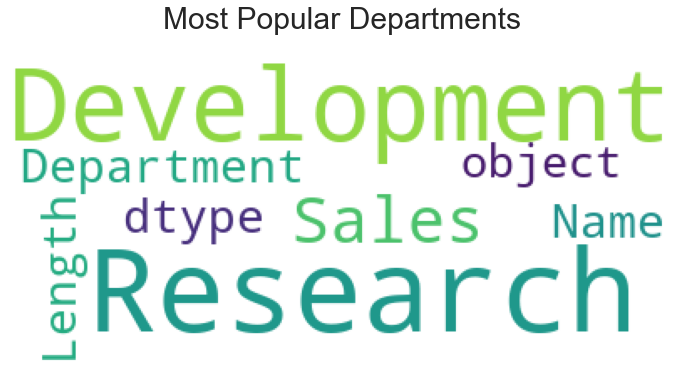

In [19]:
# Department Analysis
# Looking at the most popular departments
words_popular(general,'Department','Most Popular Departments')


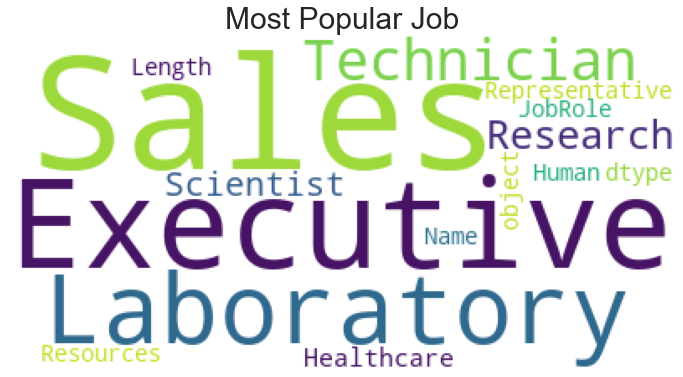

In [20]:
# Job Role Analysis
words_popular(general,'JobRole','Most Popular Job')


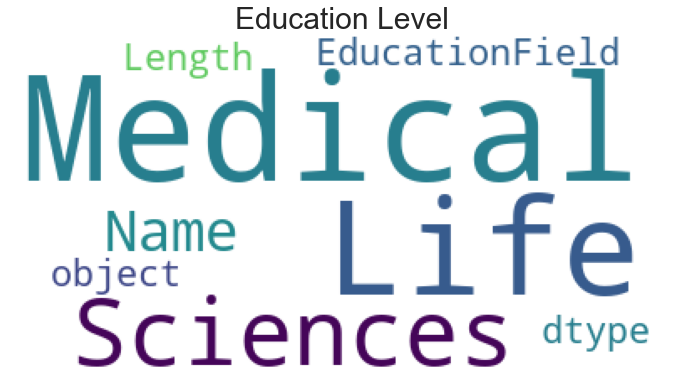

In [21]:
words_popular(general,'EducationField','Education Level')

### Employee Table Analysis

In [34]:
import plotly.express as px
# Bar chart (horizontal chart for WorkLifeBalance)
wb_df = df.groupby(['WorkLifeBalance','Attrition'])['EmployeeID'].agg(['count']).reset_index()

fig = px.bar(wb_df, x = 'count', y = 'WorkLifeBalance', orientation = 'h', color = 'Attrition', title = 'Employee By Work Life Balance')
fig.show()

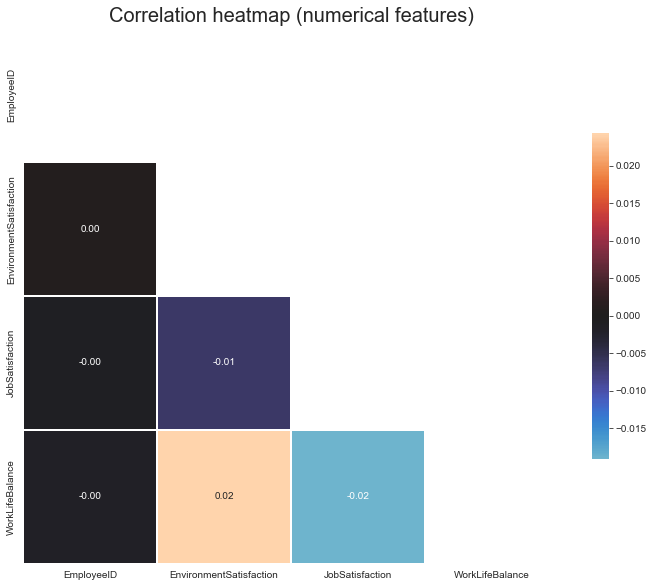

In [24]:
# Generate a heat map to check its attribute numerical correlation in employee table
f,ax = plt.subplots(figsize=(12, 12))
corr =employee.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, linewidths=.1, fmt= '.2f',ax=ax,
            center=0, square=True, cbar_kws={'shrink': .5}
            )
plt.title('Correlation heatmap (numerical features)', size=20)
plt.show();

### General Table Analysis

In [25]:
df['Temp'] = 1

In [26]:
def pie_chart(dataframe, col,target,color,title):
    plt.figure(figsize=(10,5), dpi = 100)
    target_df = dataframe.groupby([col])[target].agg(['count']).reset_index()

    plt.pie(target_df['count'],labels = target_df[col],
            autopct='%1.2f%%', startangle=45, colors=sns.color_palette(color),
            labeldistance=0.75, pctdistance=0.4)
    plt.title(title, fontsize = 20)
    plt.axis('off')
    plt.legend()
    plt.show()
    

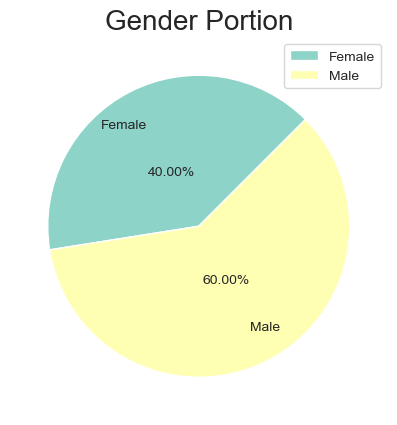

In [27]:
pie_chart(df, 'Gender','EmployeeID','Set3','Gender Portion')

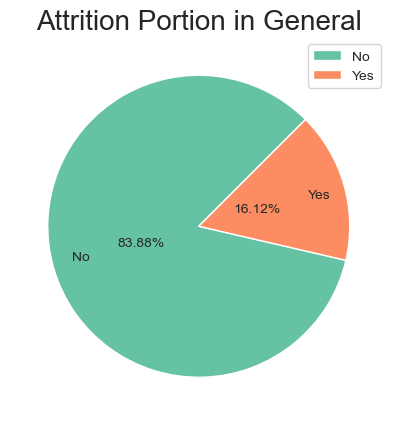

In [28]:
pie_chart(df, 'Attrition','Attrition','Set2','Attrition Portion in General')


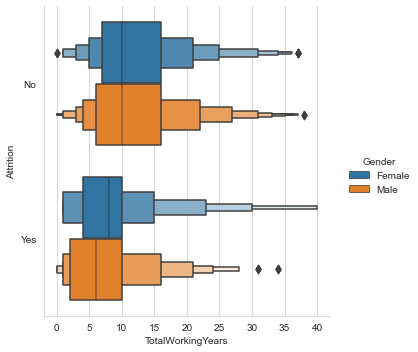

In [29]:
# To dive into the distribution of working year by Attrition
sns.catplot(
    data=df, x="TotalWorkingYears", y="Attrition", hue="Gender",
    margin_titles = True,
    kind="boxen", 
)


In [35]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating', 'Average time', 'Temp'],
      dtype='object')

In [38]:
# Number of companies employees have served
companies_employees = df.groupby(['NumCompaniesWorked','Attrition'])['EmployeeID'].agg(['count']).reset_index()
fig = px.bar(companies_employees, x='NumCompaniesWorked', y='count', color = 'Attrition')
fig.show()

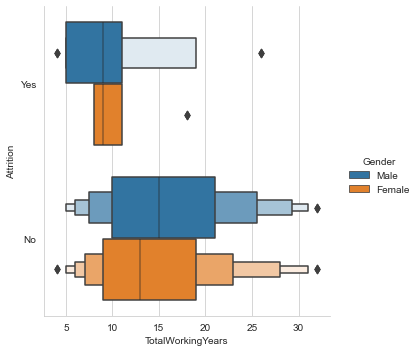

In [40]:
# If we dive deepr for employee worked for 2 companies
companies_2 = df[df['NumCompaniesWorked'] == 2]

# Gender, Department, Education Level, Business Travel

sns.catplot(
    data=companies_2, x="TotalWorkingYears", y="Attrition", hue="Gender",
    margin_titles = True,
    kind="boxen",
)

<AxesSubplot:xlabel='BusinessTravel', ylabel='Temp'>

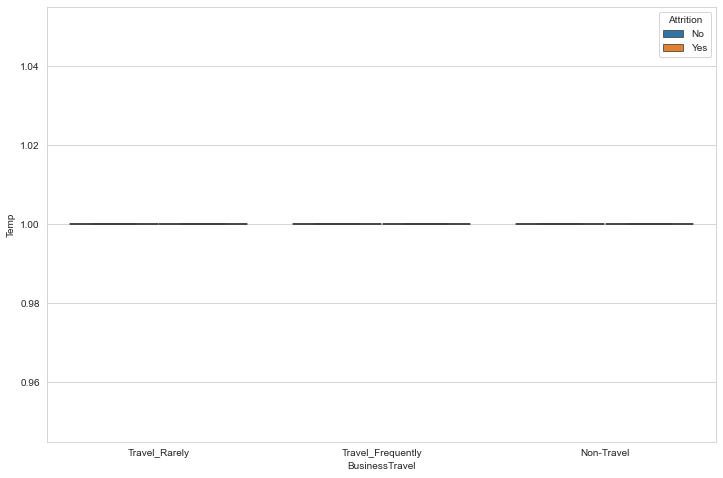

In [33]:
# To look into the age by Attrition
sns.boxplot( x = 'BusinessTravel', y = 'Temp', hue = 'Attrition', data = df)


Conclusion: TotalWorkingYear 

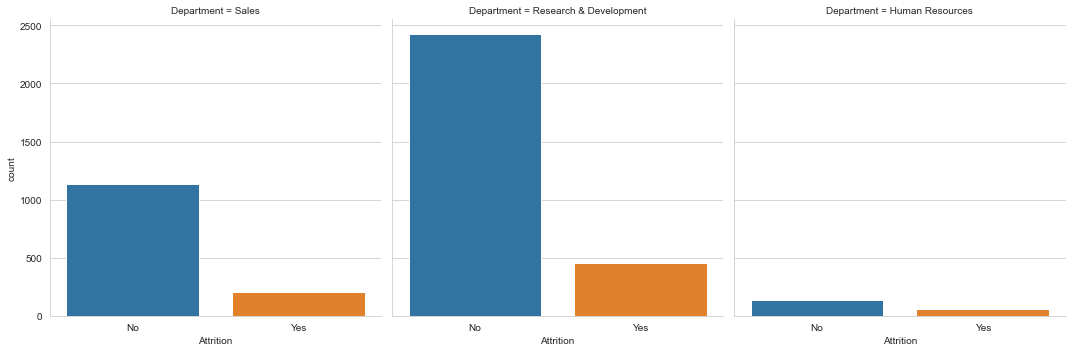

In [30]:
# Attrition by Department
sns.factorplot(data=df,kind='count',x='Attrition',col='Department')
plt.show()


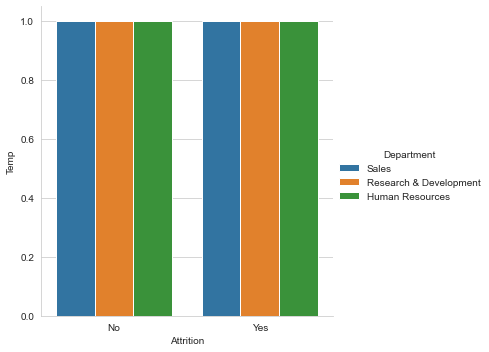

In [38]:
# Example 5: Bar plot with processed data
sns.catplot(x='Attrition', y='Temp', hue='Department', data=df, kind='bar')
plt.show()

In [42]:
fig = px.bar(df, x = 'EmployeeID', y = 'Attrition', color = 'Department', orientation = 'h',
             height = 400,
             title = 'Attrition by Department')
fig.show()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(
    y = [],
    x = [],
    name = 'Stock 1',
    orientation = 'h',
    marker = dict(
        color ='rgba(',
        line = dict(color = 'rgba(246,78,139,1)', width = 3)
    )
))



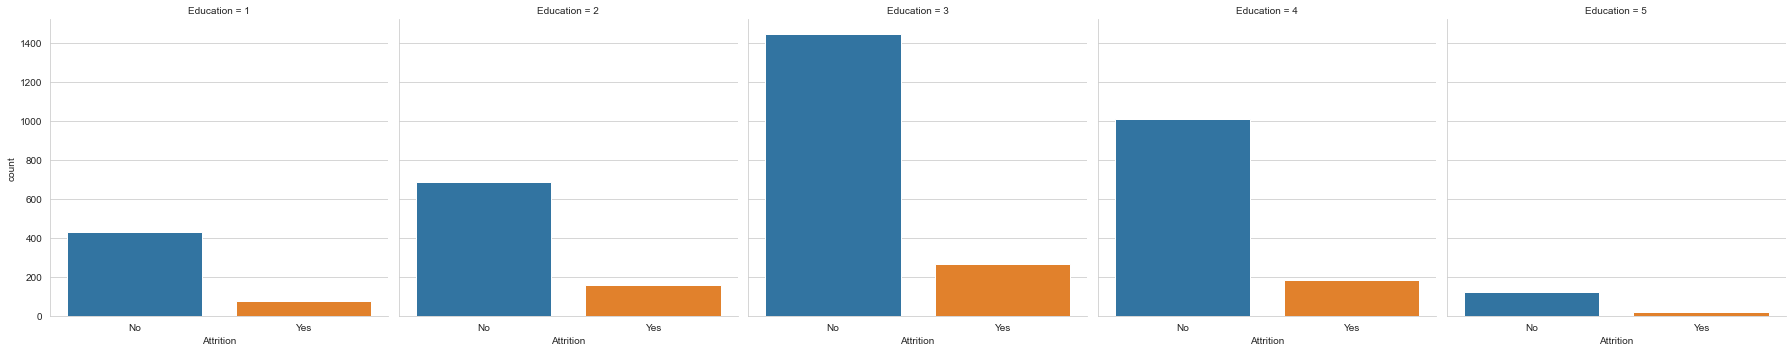

In [25]:
# Attrition by Education
sns.factorplot(data=general,kind='count',x='Attrition',col='Education')


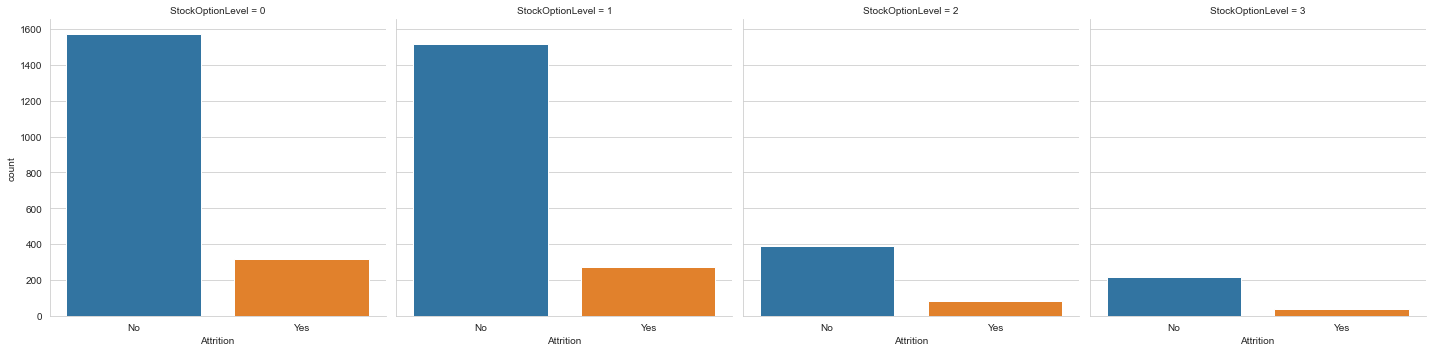

In [26]:
# Attrition by Stock Option
sns.factorplot(data=general,kind='count',x='Attrition',col='StockOptionLevel')


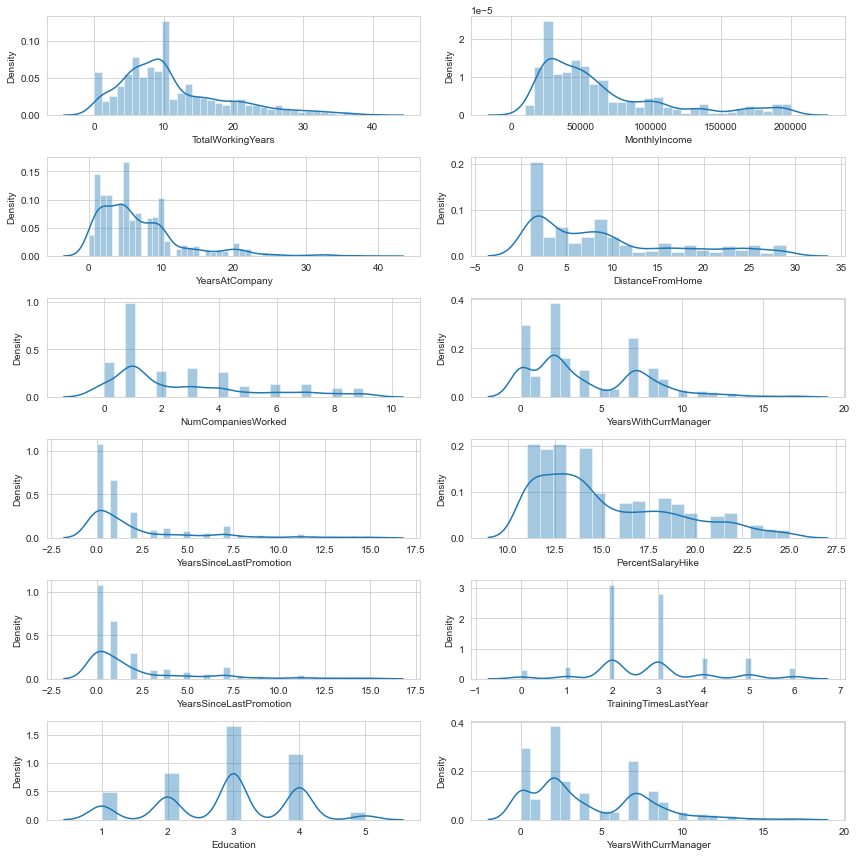

In [67]:
# Distribution of Numerical Values by Categories
fig,ax = plt.subplots(6,2, figsize=(12,12))
sns.distplot(general['TotalWorkingYears'], ax = ax[0,0])
sns.distplot(general['MonthlyIncome'], ax = ax[0,1])
sns.distplot(general['YearsAtCompany'], ax = ax[1,0])
sns.distplot(general['DistanceFromHome'], ax = ax[1,1])
sns.distplot(general['NumCompaniesWorked'], ax = ax[2,0])
sns.distplot(general['YearsWithCurrManager'], ax = ax[2,1])
sns.distplot(general['YearsSinceLastPromotion'], ax = ax[3,0])
sns.distplot(general['PercentSalaryHike'], ax = ax[3,1])
sns.distplot(general['YearsSinceLastPromotion'], ax = ax[4,0])
sns.distplot(general['TrainingTimesLastYear'], ax = ax[4,1])
sns.distplot(general['Education'], ax = ax[5,0])
sns.distplot(general['YearsWithCurrManager'], ax = ax[5,1])
plt.tight_layout()
plt.show()


In [42]:
def distribution_plt(dataframe,column_name,title,xlabel,ylabel):
    # Distribution of Age of Employees
    sns.distplot(dataframe[column_name], color = 'red')
    plt.title(title, fontsize = 30)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel(ylabel)
    plt.axvline(np.median(dataframe[column_name]), 0, linestyle='--', linewidth=1.5, color='b')
    plt.show()

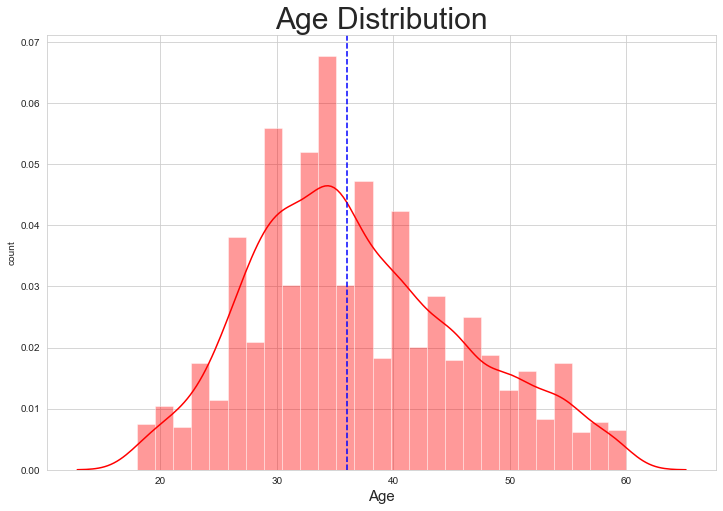

In [43]:
distribution_plt(general,'Age','Age Distribution','Age','count')

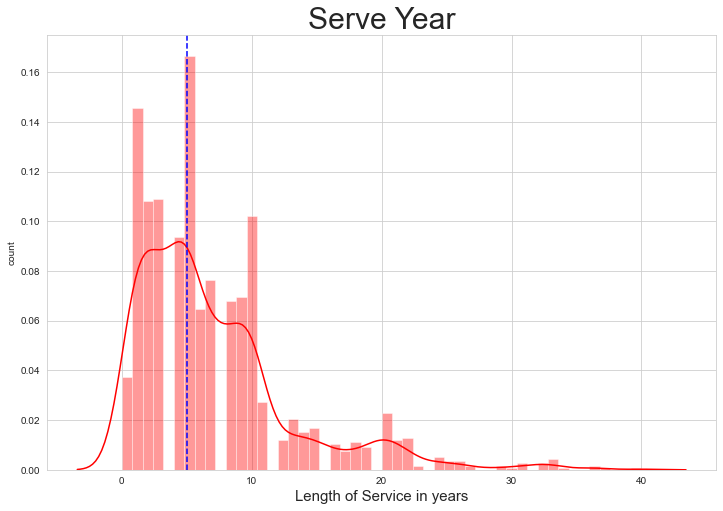

In [44]:
distribution_plt(general,'YearsAtCompany','Serve Year','Length of Service in years','count')


The Distribution of length of service is left-skewed. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


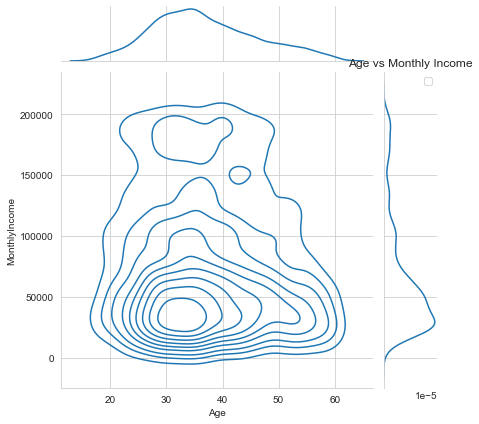

In [32]:
sns.jointplot(x="Age", y="MonthlyIncome", data=general, kind='kde')
plt.xlabel('Age')
plt.ylabel('MonthlyIncome')
plt.title('Age vs Monthly Income')

plt.legend()
plt.show()

In [35]:

# Generate a copy of employee, name it employee clean and remove its isnull rows
# Remove all isnull rows
employee_clean = employee.copy(deep = True)
employee_clean = employee_clean.merge(general, how = 'inner', on = 'EmployeeID')
employee_clean = employee_clean.merge(manager_survey, on = 'EmployeeID', how = 'inner')
employee_clean = employee_clean.dropna()

print(employee_clean.shape)
print('-'*50)
print(employee.shape)

(4300, 29)
--------------------------------------------------
(4410, 4)


In [36]:
employee_clean.columns

Index(['EmployeeID', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'Age', 'Attrition', 'BusinessTravel', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating'],
      dtype='object')

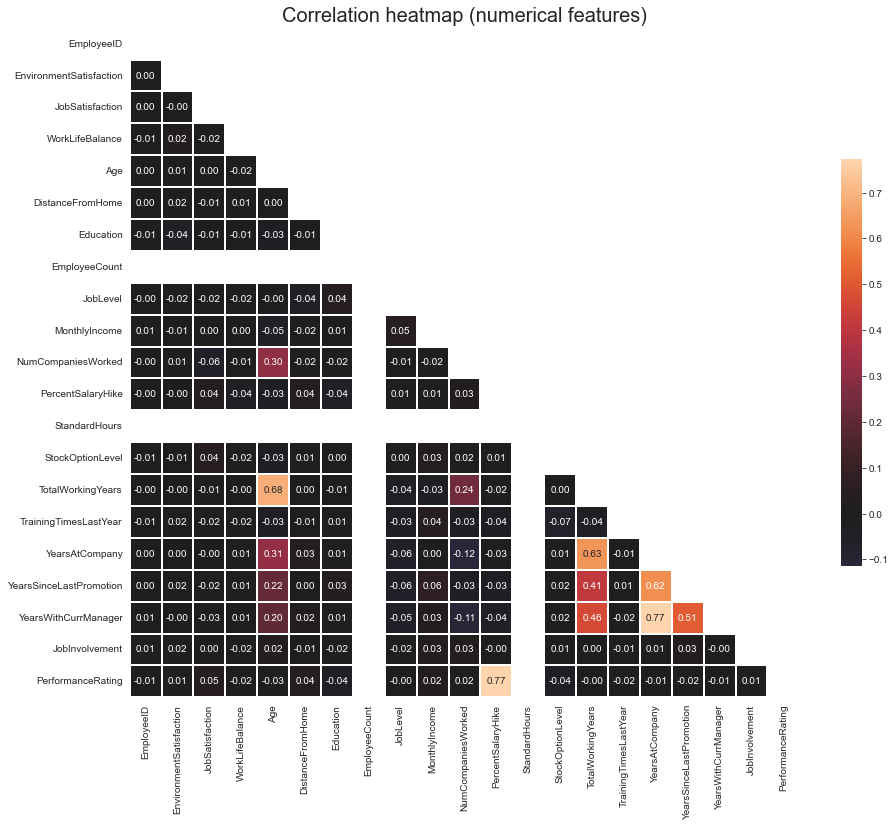

In [38]:
# Generate heatmap about employee table
f,ax = plt.subplots(figsize=(15, 15))
corr = employee_clean.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, linewidths=.1, fmt= '.2f',ax=ax,
            center=0, square=True, cbar_kws={'shrink': .5}
            )
plt.title('Correlation heatmap (numerical features)', size=20)
plt.show();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


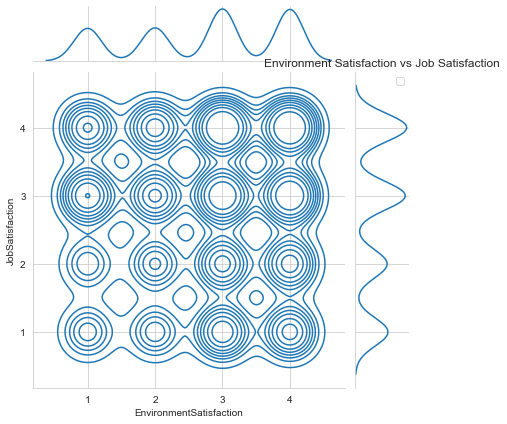

In [36]:
sns.jointplot(x="EnvironmentSatisfaction", y="JobSatisfaction", data=employee_clean, kind='kde')
plt.xlabel('Environment Satisfaction')
plt.ylabel('Job Satisfaction')
plt.title('Environment Satisfaction vs Job Satisfaction')

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


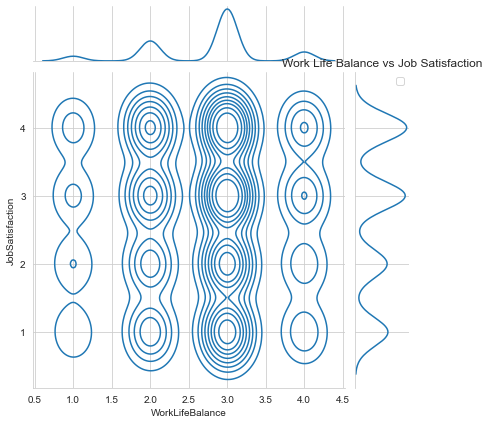

In [37]:
sns.jointplot(x="WorkLifeBalance", y="JobSatisfaction", data=employee_clean, kind='kde')
plt.xlabel('Work Life Balance')
plt.ylabel('Job Satisfaction')
plt.title('Work Life Balance vs Job Satisfaction')

plt.legend()
plt.show()

## Data Pre-processing

In [26]:
# Merge Multiple Data Tables
df = general.merge(employee, on = 'EmployeeID', how = 'inner')
df = df.merge(manager_survey, on = 'EmployeeID', how = 'inner')
#df = df.merge(in_time, on = 'EmployeeID', how = 'inner')
#df = df.merge(out_time, on = 'EmployeeID', how = 'inner')
df.head(10)

# Drop multiple cols 
df.drop(columns = ['Over18'],inplace = True)
print(df.shape)


(4410, 29)


In [27]:
duration = out_time - in_time


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [28]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Temp', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating'],
      dtype='object')

In [36]:
df['WorkLifeBalance'].unique()

array([ 2.,  4.,  1.,  3., nan])

In [59]:
# Decoding Values
df['Education'] = df['Education'].replace({ 1 : 'Below College', 2: 'College',3: 'Bachelor',4: 'Master',5 : 'Doctor'})
df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
df['JobInvolvement'] = df['JobInvolvement'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
df['JobSatisfaction'] = df['JobSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
# df['RelationshipSatisfaction'] = df['RelationshipSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
df['PerformanceRating'] = df['PerformanceRating'].replace({ 1 : 'Low', 2: 'Good',3: 'Excellent',4: 'Outstanding'})
df['WorkLifeBalance'] = df['WorkLifeBalance'].replace({ 1 : 'Bad', 2: 'Good',3: 'Better',4: 'Best'})

KeyError: 'RelationshipSatisfaction'

In [58]:
# Data Encoding
cols = ['Education','JobInvolvement','WorkLifeBalance','PerformanceRating','JobSatisfaction','EnvironmentSatisfaction']
for column in cols:
    



Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating'],
      dtype='object')

In [57]:
df.head(10)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3
5,46,No,Travel_Rarely,Research & Development,8,3,Life Sciences,1,6,Female,...,28.0,5,7,7,7,3.0,2.0,2.0,3,3
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,1,7,Male,...,5.0,2,0,0,0,1.0,3.0,1.0,3,4
7,29,No,Travel_Rarely,Research & Development,18,3,Life Sciences,1,8,Male,...,10.0,2,0,0,0,1.0,2.0,3.0,3,4
8,31,No,Travel_Rarely,Research & Development,1,3,Life Sciences,1,9,Male,...,10.0,2,9,7,8,2.0,4.0,3.0,3,4
9,25,No,Non-Travel,Research & Development,7,4,Medical,1,10,Female,...,6.0,2,6,1,5,2.0,1.0,3.0,3,3


In [45]:
import xgboost as xgb
import tensorflow as tf

# Generate some dummy data
n_samples = 100
n_features = 10
X_train = np.random.rand(n_samples, n_features)
y_train = np.random.randint(low=0, high=2, size=n_samples)

# Convert the data to TensorFlow format
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.batch(32)

# Create a TensorFlow iterator to consume the data
iterator = tf.compat.v1.data.make_initializable_iterator(train_data)
next_batch = iterator.get_next()

# Set up the XGBoost DMatrix
dtrain = xgb.DMatrix(next_batch[0], label=next_batch[1])

# Define the XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 1.0,
    'nthread': 4
}

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Initialize the TensorFlow session
with tf.compat.v1.Session() as sess:
    # Initialize the iterator
    sess.run(iterator.initializer)

    # Fetch the next batch for evaluation
    X_eval_batch, y_eval_batch = sess.run(next_batch)

    # Convert the evaluation data to XGBoost DMatrix
    deval = xgb.DMatrix(X_eval_batch, label=y_eval_batch)

    # Make predictions using the trained model
    y_pred = xgb_model.predict(deval)
    print("Predictions:", y_pred)

2023-12-28 19:43:54.246274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


RuntimeError: `make_initializable_iterator()` is not supported in eager mode. Use Python-style iteration instead.

## Classification

#### Logistic Regression

In [ ]:
y = df['Attrition']
x = df.drop('Attrition', axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
Scaler_X = StandardScaler()
X_train = Scaler_X.fit_transform(X_train)
X_test = Scaler_X.transform(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
#confusion matrix
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

###  Model Selection

In [ ]:
cols_todrop = ['JobLevel','Department','JobRole','NumCompaniesWorked','PercentSalaryHike','StockOptionLevel',
               'YearsWithCurrManager']
x = df.drop(['Attrition'], axis=1).reset_index(drop=True)
y = df['Attrition'].values
x.drop(cols_todrop, axis=1, inplace=True)
x.Age = pd.cut(x.Age, 4)

In [ ]:
x = pd.get_dummies(x)
x_copy=x.copy()

In [ ]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import r2_score, accuracy_score, roc_auc_score, mean_squared_error

In [ ]:
def get_scores(score1, score2):
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    models.append(('ADA', AdaBoostClassifier()))
    models.append(('GradientBooster', GradientBoostingClassifier()))
    models.append(('ExtraTrees', ExtraTreesClassifier()))
    models.append(('RandomForest', RandomForestClassifier()))
    cv_scores = []
    test_scores = []
    names = []
    stds = []
    differences = []
    #res = pd.DataFrame(columns = {'Model',score+('(train)'), 'Std', score+('(test_score)'), 'difference'})
    #res = res[['Model',score+('(train)'), 'Std', score+('(test_score)'), 'difference']]
    res = pd.DataFrame()
    for index, model in enumerate(models):
        kfold = StratifiedKFold(n_splits=7)
        cv_results = cross_val_score(model[1], x_train, y_train, cv=kfold, scoring=score1)
        cv_scores.append(cv_results)
        names.append(model[0])
        model[1].fit(x_train,y_train)
        predictions = model[1].predict(x_test)
        test_score = score2(predictions, y_test)
        test_scores.append(test_score)
        stds.append(cv_results.std())
        differences.append((cv_results.mean() - test_score))
        res.loc[index,'Model'] = model[0]
        res.loc[index,score1+('(train)')] = cv_results.mean()
        res.loc[index,score1+('(test_score)')] = test_score
        res.loc[index,'Std'] = cv_results.std()
        res.loc[index,'difference'] = cv_results.mean() - test_score
    return res

In [ ]:
get_scores('accuracy', accuracy_score)

In [ ]:
params = {'bootstrap': [True, False],
          'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': [1, 2, 4],
          'min_samples_split': [2, 5, 10],
          'n_estimators': [200, 400, 600, 800, 1000]}
RandomForest = RandomForestClassifier()
randomgrid_forest = RandomizedSearchCV(estimator=RandomForest, param_distributions = params,
                                       cv=5, n_iter=25, scoring = 'accuracy',
                                       n_jobs = 4, verbose = 3, random_state = 42,
                                       return_train_score = True)
randomgrid_forest.fit(x_train,y_train)

In [ ]:
forest_preds = randomgrid_forest.predict(x_test)
print(classification_report(y_test,forest_preds))

In [ ]:
feature_importances_=randomgrid_forest.best_estimator_.feature_importances_.tolist()
feature_names = x_copy.columns
pd.DataFrame(pd.Series(feature_importances_,feature_names),columns=['importance']).sort_values('importance',ascending=False)

Let's draw ROC, AUC curve

In [41]:
from sklearn.metrics import roc_curve, auc
y_score = randomgrid_forest.predict_proba(x_test)  # 随机森林
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)
def drawRoc(roc_auc,fpr,tpr):
    plt.subplots(figsize=(7, 5.5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

drawRoc(roc_auc, fpr, tpr)

NameError: name 'randomgrid_forest' is not defined

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

# Create dummy data
x_train = torch.Tensor([[1.0, 2.0], [2.0, 3.0], [3.0, 1.0], [4.0, 3.0], [5.0, 3.0],
                        [6.0, 2.0], [7.0, 3.0], [8.0, 2.0], [9.0, 3.0], [10.0, 2.0]])
y_train = torch.Tensor([[0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0]])

# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

# Initialize model
model = LogisticRegression(input_dim=2)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model
x_test = torch.Tensor([[1.0, 1.0], [2.0, 2.0], [8.0, 3.0], [9.0, 2.0]])
predictions = model(x_test)
predictions = predictions > 0.5  # Convert probabilities to binary predictions

print(f'Predictions: {predictions.flatten().tolist()}')

Epoch [100/1000], Loss: 0.6382
Epoch [200/1000], Loss: 0.5752
Epoch [300/1000], Loss: 0.5408
Epoch [400/1000], Loss: 0.5215
Epoch [500/1000], Loss: 0.5099
Epoch [600/1000], Loss: 0.5027
Epoch [700/1000], Loss: 0.4978
Epoch [800/1000], Loss: 0.4943
Epoch [900/1000], Loss: 0.4916
Epoch [1000/1000], Loss: 0.4894
Predictions: [False, False, True, True]


#### Random Forest

In [1]:
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Convert the datasets to PyTorch tensors
X = torch.tensor(X)
y = torch.tensor(y)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=0)

# Fit the classifier to the data
rf.fit(X, y)

# Make predictions on new data
new_data = torch.tensor([[5.1, 3.5, 1.4, 0.2], [6.3, 2.9, 5.6, 1.8]])
predictions = rf.predict(new_data)

# Print the predicted classes
print(predictions)

[0 2]


#### XGBoost

In [2]:
import xgboost as xgb
import torch
from torch.utils.data import DataLoader, TensorDataset

# Create a sample dataset
data = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
target = torch.tensor([0, 1, 1, 0])

# Create a PyTorch DataLoader
dataset = TensorDataset(data, target)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Convert the DataLoader to DMatrix format supported by XGBoost
dmatrix = xgb.DMatrix(dataloader)

# Train the XGBoost model
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error'
}
num_rounds = 10
model = xgb.train(params, dmatrix, num_rounds)

# Create a sample test data
test_data = torch.tensor([[2, 4, 6], [8, 10, 12]])
test_target = torch.tensor([0, 1])

# Convert the test data to DMatrix format
dtest = xgb.DMatrix(test_data)

# Predict using the trained model
predictions = model.predict(dtest)
print(predictions)


/Users/jamesli/.conda/envs/untitled/lib/python3.8/site-packages/xgboost/data.py:661: UserWarning: Unknown data type: <class 'torch.utils.data.dataloader.DataLoader'>, trying to convert it to csr_matrix
  warnings.warn(


TypeError: Not supported type for data.<class 'torch.utils.data.dataloader.DataLoader'>